# use this notebook to practice how to maneuver DALI and add augmentation in a step-wised manner 
## first check that synthetically made image data given shape  2525 x 2525 x 3

In [1]:
# validate synthetically created image size is 2525x2525x3 
import os
import random
import matplotlib.pyplot as plt
c=random.sample(os.listdir('/workspace/Data'),1)
random_img=random.sample(os.listdir('/workspace/Data/'+c[0]),1)
test=plt.imread('/workspace/Data/'+c[0]+'/'+random_img[0])
print(test.shape)

(2525, 2525, 3)


In [16]:
!nvidia-smi

Wed May 20 08:59:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   39C    P0    62W / 300W |  15777MiB / 16128MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
## make label so it is easier to visualize and do plotting 
import tensorflow as tf
tf.debugging.set_log_device_placement(True) # turn this on when you want to follow the data movement between CPU / GPU 
label2num={'notHappy':0,'Happy':1,'others':2}
num2label=dict([(b,a) for (a,b) in label2num.items()])

device_id=0

---------------------------------------------------------------------------------------------------------------

# === start with a simple pipeline that read-in the data and randomly crop patches and resize to 800 x 800 x3 ===
## run through notebook = **resize2big_image.ipynb** to create corresponding director file= **bigimgs_path.txt**

In [2]:
import tensorflow as tf

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

batch_size = 8
flag_device='cpu' # change this flag to gpu if you want to use gpu instead

## keeps the original image only read in the image as is
class OriginPipeline(Pipeline):
    def __init__(self, img_file_list,  num_shards, shard_id, batch_size, num_threads, device_id, flag_device):
        super(OriginPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.device = flag_device
        self.input_img = ops.FileReader(file_root = "", num_shards=num_shards, shard_id=shard_id, file_list=img_file_list,random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'mixed' if self.device == 'gpu' else 'cpu', output_type = types.RGB)
        self.rrc = ops.RandomResizedCrop(
                device=self.device,
                size=(800,800),
                random_area=[0.8, 0.8]
            )


    def define_graph(self):
        imgs, labels = self.input_img()
        images = self.decode(imgs)
        output = self.rrc(images)

        return (output, labels)
pipe1 = OriginPipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0, flag_device) # device_id is  

pipe1.build()

images, labels = pipe1.run()

In [3]:

if flag_device=='cpu':
    type(images.as_tensor()),images.as_tensor().shape(), labels.as_tensor().shape()
else:
    type(images.as_cpu().as_tensor()),images.as_cpu().as_tensor().shape(), labels.as_tensor().shape()

In [4]:

if flag_device=='cpu':
    imgs=np.array(images.as_tensor())
    mas=np.array(labels.as_tensor())
else:
    imgs=np.array(images.as_cpu().as_tensor())
    mas=np.array(labels.as_tensor())
len_outputs = 8


print(imgs.shape)

print(type(imgs),type(mas))
print(imgs.shape, mas.shape)


(8, 800, 800, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(8, 800, 800, 3) (8, 1)


(800, 800, 3)
[1]


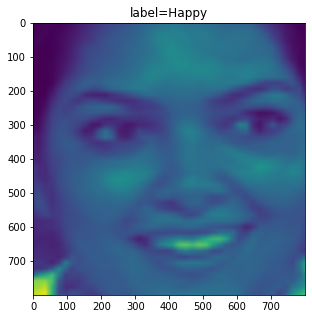

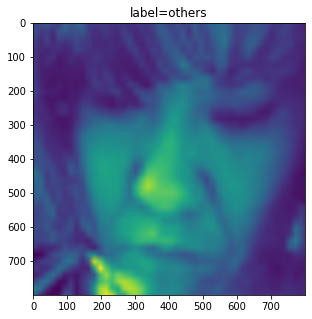

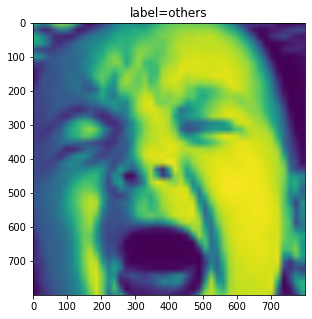

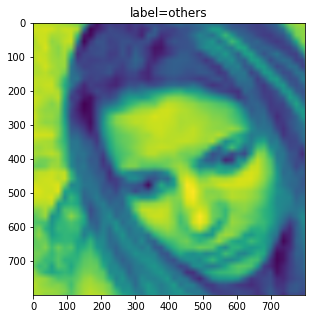

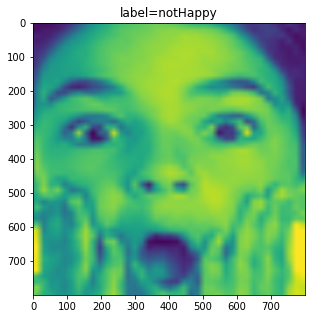

In [5]:
## plot and visualize output, verify that the processed img size is indeed 800x800x3
print(imgs[0].shape)
print(mas[0])
show_many=5
cnt=0
for i in range(show_many):
    im=imgs[i].reshape(800,800,3)
    label=mas[i][0]
    plt.figure(figsize = (5,5))
    plt.imshow(im)
    plt.title("label={}".format(num2label[label]))

    plt.show()
    ### one can save the augmented images here( with size 224x224x3 ) as an alternative
    ### if you uncomment the below, you will also need to specify the batch_size to be larger , for example batch_size=8*8
    #cv2.imwrite('/workspace/small/{}/{}_{}.png'.format(label_map[labels[rn][0]],label_map[labels[rn][0]],str(cnt)),im)
    #cnt+=1
del pipe1

---------------------------------------------------------------------------------------------------------------

# === next we add flip + resize to 224x224x3  and create a new pipeline named Opt3Pipeline  ===
## run through notebook = **resize2big_image.ipynb** to create corresponding director file= **bigimgs_path.txt**

In [7]:
import tensorflow as tf

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

batch_size = 8

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

batch_size = 8
class Opt2Pipeline(Pipeline):
    def __init__(self, img_file_list,  num_shards, shard_id, batch_size, num_threads, device_id, flag_device):
        super(Opt2Pipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.device = flag_device
        self.input_img = ops.FileReader(file_root = "", num_shards=num_shards, shard_id=shard_id, file_list=img_file_list,random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'mixed' if self.device == 'gpu' else 'cpu', output_type = types.RGB)
        self.rrc = ops.RandomResizedCrop(
                device=self.device,
                size=(800,800),
                random_area=[0.8, 0.8])
        self.flip_v = ops.Flip(device = self.device, vertical = 1, horizontal = 0)
        self.resize = ops.Resize(device=self.device, resize_x=224, resize_y=224)
        


    def define_graph(self):
        imgs, labels = self.input_img()
        images = self.decode(imgs)
        output = self.rrc(images)
        output = self.flip_v(output)
        output = self.resize(output)

        return (output, labels)
pipe2 = Opt2Pipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0, flag_device)

pipe2.build()

images2, labels2 = pipe2.run()

In [8]:
len_outputs = 8

if flag_device=='cpu':
    type(images2.as_tensor()),images2.as_tensor().shape(), labels2.as_tensor().shape()
    imgs2=np.array(images2.as_tensor())
    mas2=np.array(labels2.as_tensor())
else:
    type(images2.as_cpu().as_tensor()),images2.as_cpu().as_tensor().shape(), labels2.as_tensor().shape()
    imgs2=np.array(images2.as_cpu().as_tensor())
    mas2=np.array(labels2.as_tensor())

print(type(imgs2),type(mas2))
print(imgs2.shape, mas2.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(8, 224, 224, 3) (8, 1)


(224, 224, 3)
[1]


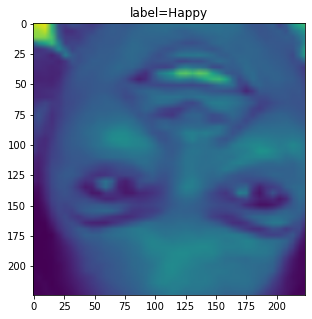

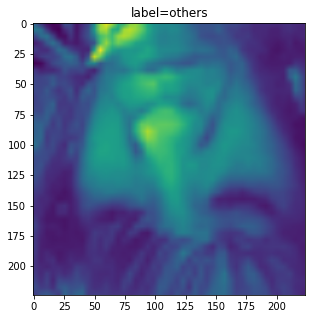

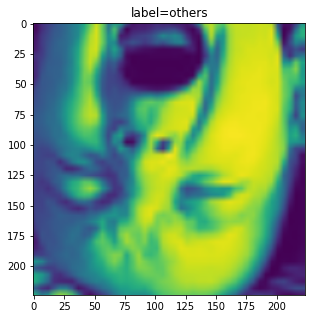

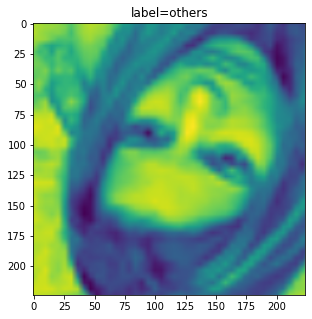

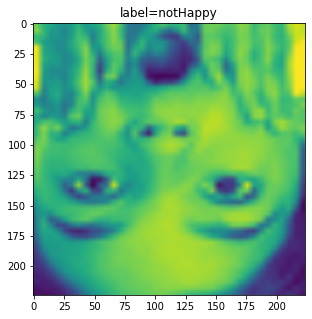

In [9]:
print(imgs2[0].shape)
print(mas2[0])
show_many=5
for i in range(show_many):
    im=imgs2[i].reshape(224,224,3)
    label=mas2[i][0]
    plt.figure(figsize = (5,5))
    plt.imshow(im)
    plt.title("label={}".format(num2label[label]))

    plt.show()
del pipe2

---------------------------------------------------------------------------------------------------------------

[9, 12, 21, 3, 2, 14, 16, 24, 14, 23]

# === next we add flip+ **rotate** + resize to 224x224x3  and create a new pipeline named Opt3Pipeline ===
## run through notebook = **resize2big_image.ipynb** to create corresponding director file= **bigimgs_path.txt**

In [10]:
import tensorflow as tf

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline
Yes_rotate=True
batch_size = 4
class Opt3Pipeline(Pipeline):
    def __init__(self, img_file_list,  num_shards, shard_id, batch_size, num_threads, device_id, Yes_rotate, flag_device):
        super(Opt3Pipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.device=flag_device
        self.input_img = ops.FileReader(file_root = "", num_shards=num_shards, shard_id=shard_id, file_list=img_file_list,random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = 'mixed' if self.device == 'gpu' else 'cpu', output_type = types.RGB)
        self.rrc = ops.RandomResizedCrop(
                device=self.device,
                size=(800,800),
                random_area=[0.8, 0.8])
        self.flip_h = ops.Flip(device = self.device, vertical = 0, horizontal = 1)
        if Yes_rotate:
            self.resize1=ops.Resize(device=self.device, resize_x=224*math.sqrt(2), resize_y=224*math.sqrt(2))
            self.rotate = ops.Rotate(device = self.device, angle = 15*random.randint(0,24), interp_type = types.INTERP_LINEAR, fill_value = 0) # one can indicate what other fill_value you want
            self.resize = ops.Resize(device=self.device, resize_x=224, resize_y=224)
        


    def define_graph(self):
        imgs, labels = self.input_img()
        images = self.decode(imgs)
        output = self.rrc(images)
        output = self.flip_h(output)
        if Yes_rotate:
            output = self.resize1(output)
            output = self.rotate(output)
            output = self.resize(output)
        return (output, labels)

pipe3 = Opt3Pipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0, Yes_rotate,flag_device)

pipe3.build()

images3, labels3 = pipe3.run()
len_outputs = 8
if flag_device=='gpu':
    imgs3=np.array(images3.as_cpu().as_tensor())
else:
    imgs3=np.array(images3.as_tensor())

print(imgs3.shape)
mas3=np.array(labels3.as_tensor())
print(type(imgs3),type(mas3))
print(imgs3.shape, mas3.shape)

(4, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4, 224, 224, 3) (4, 1)


(224, 224, 3)
[1]


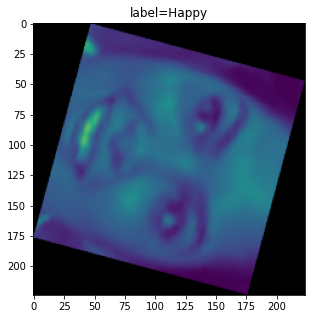

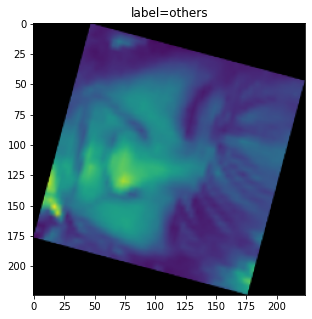

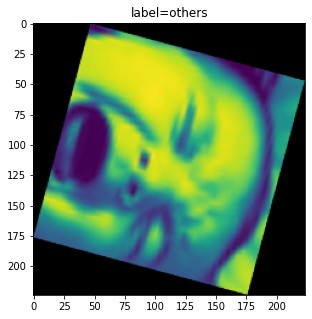

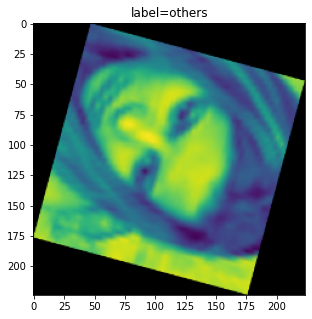

In [11]:
### visualize once only, moving image back to CPU is expensive, we dont do that when we using DALI to pipe data directly into model ( which is ALSO on GPU =0)
print(imgs3[0].shape)
print(mas3[0])
show_many=4
for i in range(show_many):
    im=imgs3[i].reshape(224,224,3)
    label=mas3[i][0]
    plt.figure(figsize = (5,5))
    plt.imshow(im)
    plt.title("label={}".format(num2label[label]))

    plt.show()
del pipe3

In [13]:
import tensorflow.compat.v1 as tf
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.plugin.tf as dali_tf
tf.logging.set_verbosity(tf.logging.ERROR)
batch_size=2
pipe4 = Opt3Pipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0,Yes_rotate, flag_device)


daliop = dali_tf.DALIIterator()
DEFINE_dtype = tf.float16
DEFINE_dtype = tf.float16
BATCH_SIZE=batch_size
# Define shapes and types of the outputs
# Define shapes and types of the outputs
shapes = [
    (4, 224, 224,3),
    (4,1)]
dtypes = [
    tf.float32,
    tf.int32]


# Create tensorflow dataset

out_dataset = dali_tf.DALIDataset(
    pipeline=pipe4,
    batch_size=batch_size,
    shapes=shapes,
    dtypes=dtypes,
    device_id=0)

type(out_dataset)


Executing op DALIDataset in device /job:localhost/replica:0/task:0/device:GPU:0


nvidia.dali.plugin.tf._DALIDatasetV2

In [14]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224,3), name='images'),
    tf.keras.layers.Flatten(input_shape=(224, 224)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train using DALI dataset
model.fit(
    out_dataset,
    epochs=1,
    steps_per_epoch=2,
    use_multiprocessing=True
)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def get_reset50_model():
    # load model without classifier layers
    num_class=3
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    # make all layers trainable
    for layer in base_model.layers:
        layer.trainable = True
    # add your head on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_class, activation='softmax')(x)

    m = Model(inputs=base_model.input, outputs=output)
    return m

if flag_device=='cpu':
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(224, 224,3), name='images'),
        tf.keras.layers.Flatten(input_shape=(224, 224)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(3, activation='softmax')])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    # Train using DALI dataset
    model.fit(
        out_dataset,
        epochs=1,
        steps_per_epoch=2,
        use_multiprocessing=True
    )
else:
    with tf.device('/gpu:0'):
        m=get_reset50_model()
        m.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        # Train using DALI dataset
        m.fit(
            out_dataset,
            epochs=1,
            steps_per_epoch=10,
            use_multiprocessing=True
        )

Train for 2 steps
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandle